In [1]:
%pip install --user --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for extract_lfaa_pcap_info

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-yg_0yn46
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-yg_0yn46
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit f53508893632c03534bafeeb39a4ffbf3bf38bd9
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np

from ska_low_csp_test.pcap import extract_lfaa_pcap_info

In [3]:
!ls -lh /mnt/clp-k8s-fpga-worker-1/pcap/output | tail -n3

-rw-r--r-- 1 jovyan jovyan 12M Mar 22 09:16 20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap
-rw-r--r-- 1 jovyan jovyan 12M Mar 22 09:23 20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap.npy
-rw-r--r-- 1 jovyan jovyan 22M Mar 21 15:43 foo.npy


## Display test data

In [4]:
filepath = "/mnt/clp-k8s-fpga-worker-1/pcap/output"
pcaplist = []
for file in listdir(filepath):
    if file.endswith(".sps.pcap"):
        pcaplist += [file]
pcaplist.sort()
pcapfiles = [join(filepath, f) for f in pcaplist if isfile(join(filepath, f))]
filename = pcapfiles[-1]
print(filename)

/mnt/clp-k8s-fpga-worker-1/pcap/output/20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap


In [5]:
print(f"Data file {filename}")
pcap_info = extract_lfaa_pcap_info(filename)
print(f"  has {pcap_info.packet_count} packets of size {pcap_info.packet_size} bytes")
print(f"  simulating data from {pcap_info.station_count} stations")
frequencies = pcap_info.station_channel_frequency[0]
print(f"  for {pcap_info.channel_count} channels: {pcap_info.frequency_ids}")
print(f"  with frequencies {list(frequencies / 1e6)} MHz")

Data file /mnt/clp-k8s-fpga-worker-1/pcap/output/20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap
  has 1440 packets of size 8306 bytes
  simulating data from 5 stations
  for 96 channels: {208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303}
  with frequencies [162.5, 163.28125, 164.0625, 164.84375, 165.625, 166.40625, 167.1875, 167.96875, 168.75, 169.53125, 170.3125, 171.09375, 171.875, 172.65625, 173.4375, 174.21875, 175.0, 175.78125, 176.5625, 177.34375, 178.125, 178.90625, 179.6875, 180.46875, 181.25, 182.03125, 182.8125, 183.59375, 184.375, 185.15625, 185

In [6]:
print(np.shape(pcap_info.channelized_data))
channel_data = np.mean(pcap_info.channelized_data, axis=-1)
print(channel_data.shape)
[_, n_stations, n_chans, _] = channel_data.shape
print(n_stations, n_chans)

(3, 5, 96, 4, 2048)
(3, 5, 96, 4)
5 96


In [7]:
# Convert real,imag dimensions into complex array
#     c_arr = arr[...,0] + arr[...,1] * 1j
v_channels = channel_data[:, 0, :, 0] + 1j * channel_data[:, 0, :, 1]
h_channels = channel_data[:, 0, :, 2] + 1j * channel_data[:, 0, :, 3]

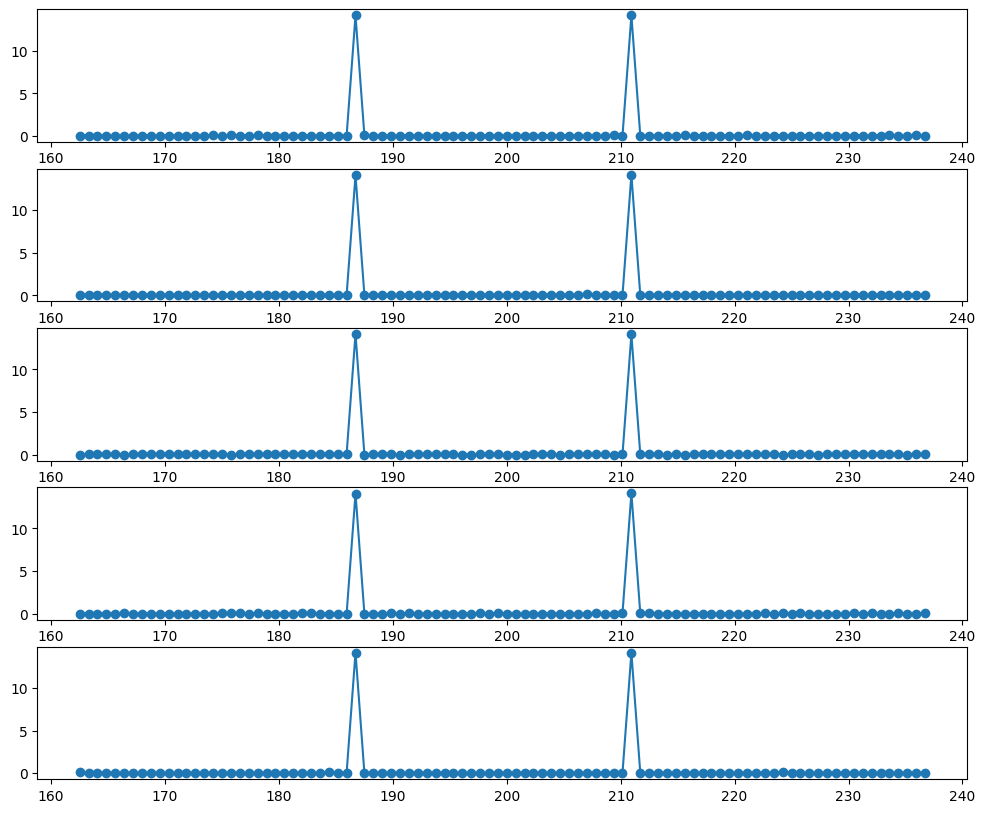

In [8]:
# 1e6 is to convert Hz to MHz
values_x = pcap_info.station_channel_frequency[0] / 1e6
fig, axes = plt.subplots(nrows=n_stations, ncols=1, figsize=(12, 10))
for idx in range(n_stations):
    v_channels = channel_data[:, idx, :, 0] + 1j * channel_data[:, idx, :, 1]
    values_y = np.abs(np.mean(v_channels, axis=0))
    axes[idx].plot(values_x, values_y, "o-")

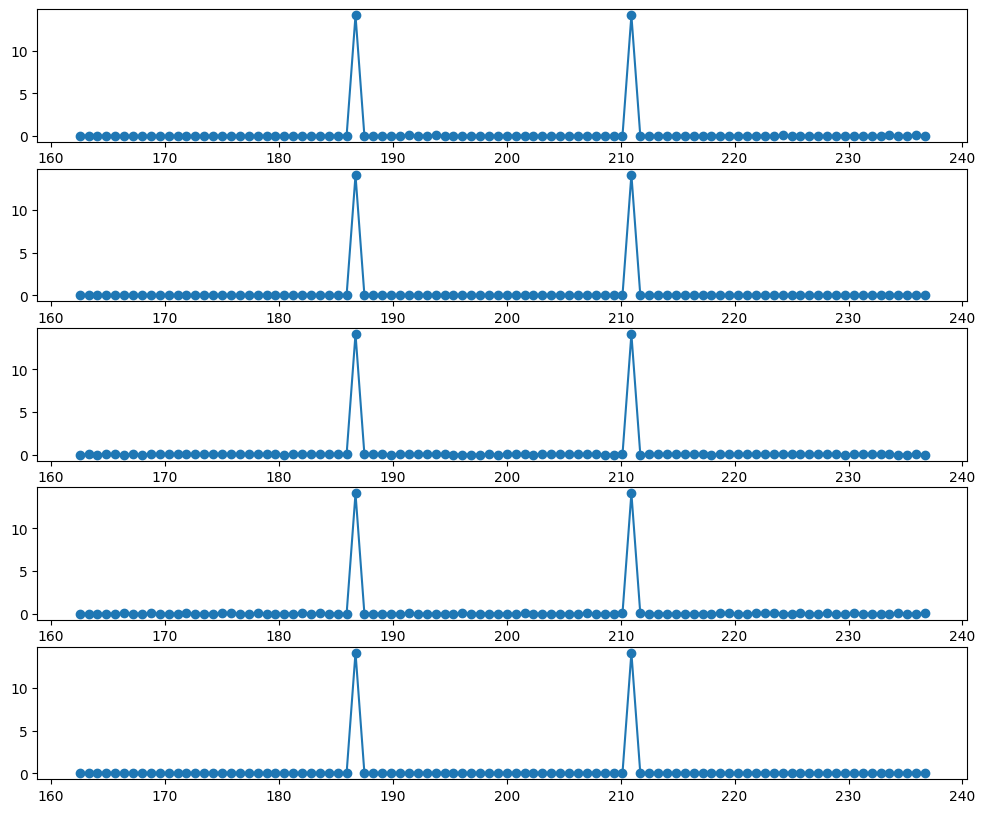

In [9]:
# 1e6 is to convert Hz to MHz
values_x = pcap_info.station_channel_frequency[0] / 1e6
fig, axes = plt.subplots(nrows=n_stations, ncols=1, figsize=(12, 10))
for idx in range(n_stations):
    h_channels = channel_data[:, idx, :, 1] + 1j * channel_data[:, idx, :, 3]
    values_y = np.abs(np.mean(h_channels, axis=0))
    axes[idx].plot(values_x, values_y, "o-")